In [2]:
import pandas as pd
import torch.optim as optim
import torch
import numpy as np
from transformers import BertTokenizer, BertModel, pipeline
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

device = torch.device('cuda')


In [4]:
imdb = pd.read_csv('./data/IMDB/origin_dataset.csv')

In [5]:
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
imdb['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

X = imdb.drop(columns=['sentiment'])  # 'sentiment' 열을 제외한 데이터 (피처)
y = imdb['sentiment'] 

# Step 1: Train (80%) vs Temp (20%) 나누기 (라벨 비율 유지)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=80
)

# Step 2: Temp 데이터를 Validation (10%) vs Test (10%)로 나누기 (라벨 비율 유지)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=80
)

print(f"Train 데이터 크기: {X_train.shape}, 라벨 분포:\n{y_train.value_counts(normalize=True)*100}")
print(f"Validation 데이터 크기: {X_val.shape}, 라벨 분포:\n{y_val.value_counts(normalize=True)*100}")
print(f"Test 데이터 크기: {X_test.shape}, 라벨 분포:\n{y_test.value_counts(normalize=True)*100}")

Train 데이터 크기: (40000, 1), 라벨 분포:
positive    50.0
negative    50.0
Name: sentiment, dtype: float64
Validation 데이터 크기: (5000, 1), 라벨 분포:
negative    50.0
positive    50.0
Name: sentiment, dtype: float64
Test 데이터 크기: (5000, 1), 라벨 분포:
positive    50.0
negative    50.0
Name: sentiment, dtype: float64


In [9]:
X_train['sentiment'] = y_train
X_val['sentiment'] = y_val
X_test['sentiment'] = y_test

X_train.to_csv("data/IMDB/train.csv", index=False)
X_val.to_csv("data/IMDB/valid.csv", index=False)
X_test.to_csv("data/IMDB/test.csv", index=False)

### PreProcess

In [10]:
import torch
from transformers import BertTokenizer
import re
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline

class NERTagger:
    def __init__(self, model_name="dbmdz/bert-large-cased-finetuned-conll03-english"):
        """
        사전 학습된 NER 모델을 불러옴 (CONLL-03 데이터셋 기반)
        """
        self.ner_pipeline = pipeline("ner", model=model_name, aggregation_strategy="simple", device=device)

    def extract_named_entities(self, text):
        """
        입력된 텍스트에서 특정 개체명을 추출하여 리스트로 반환
        """
        entities = self.ner_pipeline(text)
        target_entities = []

        for entity in entities:
            if entity["entity_group"] in ["ORG", "NORP", "GPE", "LOC", "EVENT"]:
                target_entities.append(entity["word"])

        return target_entities


class NERProcessor:
    def __init__(self, tokenizer, ner_tagger, use_ner):
        self.tokenizer = tokenizer
        self.ner_tagger = ner_tagger
        self.use_ner = use_ner

    def extract_head_token(self, text):
        """
        NER을 적용하여 특정 개체명을 Head-Token으로 선정.
        Head-Token이 없으면 [CLS]를 사용.
        """
        if not self.use_ner:
            return None
        
        entities = self.ner_tagger.extract_named_entities(text)
        if len(entities) > 0:
            return entities[0]  # 첫 번째 개체명을 Head-Token으로 사용
        return None  # 개체명이 없는 경우

    def tokenize_and_encode(self, text):
        """
        문장을 BERT Tokenizer를 이용해 토큰화하고, Head-Token의 인덱스를 반환.
        """
        head_token = self.extract_head_token(text)
        tokens = self.tokenizer.tokenize(text)
        token_ids = self.tokenizer.encode(text, truncation=True, padding="max_length", max_length=512)

        # Head-Token이 존재하는 경우 인덱스를 찾음
        if head_token:
            try:
                head_token_idx = tokens.index(head_token) + 1  # [CLS]가 0번째이므로 +1
            except ValueError:
                head_token_idx = 0  # 찾지 못한 경우 기본값 ([CLS]) 설정
        else:
            head_token_idx = 0  # 개체명이 없으면 [CLS]를 Head-Token으로 설정

        return token_ids, head_token_idx


### Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class HeadAttention(nn.Module):
    def __init__(self, hidden_dim, head_dim):
        super(HeadAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.head_dim = head_dim

        self.W_q = nn.Linear(hidden_dim, head_dim, bias=False)
        self.W_k = nn.Linear(hidden_dim, head_dim, bias=False)
        self.W_v = nn.Linear(hidden_dim, head_dim, bias=False)

    def forward(self, cls_embedding, head_token_embedding):
        Q_h = self.W_q(cls_embedding)   # [CLS]의 Query
        K_h = self.W_k(head_token_embedding)  # 특정 토큰의 Key
        V_h = self.W_v(head_token_embedding)  # 특정 토큰의 Value

        attention_scores = torch.matmul(Q_h, K_h.T) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        output = torch.matmul(attention_weights, V_h)
        return output
    

class CustomBERT(nn.Module):
    def __init__(self, bert_model_name, hidden_dim):
        super(CustomBERT, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_dim = hidden_dim

        # Head-Attention 추가
        self.head_attention = HeadAttention(hidden_dim, hidden_dim)

        # 최종 분류기
        self.classifier = nn.Linear(hidden_dim, 2)  # non-hate(0) / hate(1) 이진 분류

    def forward(self, input_ids, head_token_idx):
        outputs = self.bert(input_ids)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰 출력

        # Head-Token 위치 추출
        batch_size = input_ids.shape[0]
        head_token_embeddings = outputs.last_hidden_state[torch.arange(batch_size), head_token_idx, :]

        # Head-Token이 없을 경우 기본적으로 Self-Attention 사용
        if torch.all(head_token_idx == 0):  
            final_embedding = cls_embedding  # 기본적인 [CLS] Embedding 사용
        else:
            head_attention_output = self.head_attention(cls_embedding, head_token_embeddings)
            final_embedding = cls_embedding + head_attention_output  # Head-Attention 결합

        logits = self.classifier(final_embedding)
        return logits


### DataLoad

In [8]:
class CustomNERDataset(Dataset):
    def __init__(self, csv_file, tokenizer, ner_tagger, use_ner):
        """
        csv_file: 데이터 파일 경로 (post, label)
        tokenizer: BERT 토크나이저
        ner_tagger: NER 태깅 모델
        """
        if ".tsv" in csv_file:
            self.data = pd.read_csv(csv_file, delimiter="\t")
        else:
            self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.processor = NERProcessor(tokenizer, ner_tagger, use_ner)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text, label = row["post"], row["label"]

        # 토큰화 및 Head-Token 인덱스 추출
        token_ids, head_token_idx = self.processor.tokenize_and_encode(text)
        token_ids = torch.tensor(token_ids, dtype=torch.long)
        head_token_idx = torch.tensor(head_token_idx, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)

        return {
            "input_ids": token_ids,
            "head_token_idx": head_token_idx,
            "label": label
        }

def collate_fn(batch):
    """
    DataLoader에서 batch 단위로 데이터를 처리하는 함수
    """
    input_ids = torch.stack([item["input_ids"] for item in batch])
    head_token_idx = torch.stack([item["head_token_idx"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])

    return {
        "input_ids": input_ids,
        "head_token_idx": head_token_idx,
        "labels": labels
    }

# 데이터 로더 설정
def get_dataloader(csv_file, tokenizer, ner_tagger, use_ner, batch_size=16, shuffle=True):
    print("---Start dataload---")
    dataset = CustomNERDataset(csv_file, tokenizer, ner_tagger, use_ner)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    print("---End dataload---")
    return dataloader


### Train

In [5]:
import random

def set_seed(seed=42):
    """
    랜덤 시드를 고정
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # GPU 사용 시에도 시드 고정

    # CUDNN 설정 (연산 속도 vs 재현성 선택)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 고정 실행

In [7]:
def train_epoch(dataloader, model, optimizer, criterion):
    print("---Start train!---")
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        head_token_idx = batch["head_token_idx"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, head_token_idx)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(dataloader, model):
    print("---Start Valid!---")
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            head_token_idx = batch["head_token_idx"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, head_token_idx)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    
    return accuracy, f1

In [ ]:
import os

set_seed(0)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
ner_tagger = NERTagger()
MODEL_SAVE_PATH = "./save/ihc/best_model.pth"

train_loader = get_dataloader("./data/ihc/train.tsv", tokenizer, ner_tagger, use_ner=True, batch_size=16)
valid_loader = get_dataloader("./data/ihc/valid.tsv", tokenizer, ner_tagger, use_ner=False, batch_size=16)

model = CustomBERT('bert-base-uncased', hidden_dim=768).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

best_f1_score = 0.0
num_epochs = 6
for epoch in range(num_epochs):
    print(f"epoch {epoch+1}")
    train_loss = train_epoch(train_loader, model, optimizer, criterion)
    acc, f1 = evaluate(valid_loader, model)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

    if f1 > best_f1_score:
        best_f1_score = f1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✅ Model saved at epoch {epoch+1} with F1-score: {f1:.4f}")

### Test

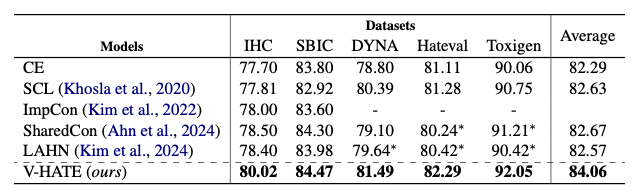

In [ ]:
# 테스트 데이터 로더 생성
set_seed(0)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = CustomBERT('bert-base-uncased', hidden_dim=768).to(device)
ner_tagger = NERTagger()
MODEL_SAVE_PATH="./save/toxigen/2/best_model.pth"

test_loader = get_dataloader("./data/toxigen/test.csv", tokenizer, ner_tagger, use_ner=False, batch_size=16, shuffle=False)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.to(device)

In [ ]:
def test_model(dataloader, model):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            head_token_idx = batch["head_token_idx"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, head_token_idx)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    
    return accuracy, f1, predictions, true_labels

In [ ]:
test_accuracy, test_f1, y_pred, y_true = test_model(test_loader, model)

print(f"Test Accuracy: {test_accuracy*100:.2f}")
print(f"Test F1-Score: {test_f1*100:.2f}")